In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'zh'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'tuned-chinese-en'


In [4]:
# Parameters
model_size = "7b"
target_lang = "fr"
input_lang = "de"
type = "tuned-chinese-en"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()

In [6]:

llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
    
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
if type == 'tuned-chinese-en':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese-en'
    latent = 'en'
    chinese = pd.read_csv(f'{prefix}zh/clean.csv').reindex()
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [8]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    if latent == 'zh':
      df_en_target_input = df_en_target.copy()
      chinese = chinese.loc[chinese["word_original"].isin(df_en_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]
    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation': target_lang if target_lang != latent else f'{latent}_tgt'}, 
                                inplace=True)
    
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    if latent == 'zh':
      chinese = chinese.loc[chinese["word_original"].isin(df_en_target_input["word_original"])]
      df_en_target_input= df_en_target_input.loc[df_en_target_input["word_original"].isin(chinese["word_original"])]
      chinese.sort_values(by="word_original", inplace=True)
      df_en_target_input.sort_values(by="word_original", inplace=True)
      chinese.reset_index(drop=True, inplace=True)
      df_en_target_input.reset_index(drop=True, inplace=True)
      df_en_target_input["word_original"] = chinese["word_translation"]

    df_en_target_input.rename(columns={'word_original': latent, 
                                f'word_translation_{target_lang}': target_lang if target_lang != latent else f'{latent}_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != latent else f'{latent}_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != latent:
    for i, row in df_en_target_input.iterrows():
        if row[latent].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_{latent}_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for fr 68 of 118 are single tokens
final length of df_en_fr_de: 94


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != latent and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
df_en_target_input

,lang_fr,en,fr,blank_prompt_original_fr,blank_prompt_translation_fr,blank_prompt_translation_masked_fr,error_fr,lang_de,de,blank_prompt_original_de,blank_prompt_translation_de,blank_prompt_translation_masked_de,error_de
0,fr,cloud,nuage,"A ""cloud"" is a visible mass of condensed water...","Un ""nuage"" est une masse visible de vapeur d'e...","Un ""___"" est une masse visible de vapeur d'eau...",no error,de,Wolke,"A ""cloud"" is a visible mass of condensed water...","Eine ""Wolke"" ist eine sichtbare Masse aus kond...","Eine ""___"" ist eine sichtbare Masse aus konden...",no error
1,fr,bag,sac,"A ""bag"" is used to carry items. Answer: ""bag"".","Un ""sac"" est utilisé pour transporter des obje...","Un ""___"" est utilisé pour transporter des obje...",no error,de,Tasche,"A ""bag"" is used to carry items. Answer: ""bag"".","Eine ""Tasche"" wird zum Tragen von Gegenständen...","Eine ""___"" wird zum Tragen von Gegenständen ve...",no error
2,fr,mouth,bouche,"A ""mouth"" is used to eat food and speak. Answe...","La ""bouche"" sert à manger et à parler. Réponse...","La ""___"" sert à manger et à parler. Réponse : ...",no error,de,Mund,"A ""mouth"" is used to eat food and speak. Answe...","Ein ""Mund"" wird zum Essen und Sprechen benutzt...","Ein ""___"" wird zum Essen und Sprechen benutzt....",no error
3,fr,soil,sol,"""A ""soil"" is used for planting trees and crops...","""Un ""sol"" est utilisé pour planter des arbres ...","""Un ""___"" est utilisé pour planter des arbres ...",no error,de,Boden,"""A ""soil"" is used for planting trees and crops...","""Ein ""Boden"" wird für die Anpflanzung von Bäum...","""Ein ""___"" wird für die Anpflanzung von Bäumen...",no error
4,fr,mountain,montagne,"A ""mountain"" is a large natural elevation of t...","Une ""montagne"" est une grande élévation nature...","Une ""___"" est une grande élévation naturelle d...",no error,de,Berg,"A ""mountain"" is a large natural elevation of t...","Ein ""Berg"" ist eine große natürliche Erhebung ...","Ein ""___"" ist eine große natürliche Erhebung a...",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,fr,office,bureau,"An ""office"" is a place where people usually do...","Un ""bureau"" est un endroit où les gens font ha...","Un ""___"" est un endroit où les gens font habit...",no error,de,Büro,"An ""office"" is a place where people usually do...","Ein ""Büro"" ist ein Ort, an dem Menschen normal...","Ein ""___"" ist ein Ort, an dem Menschen normale...",no error
105,fr,rise,hausse,"""A ""rise"" is used to describe an increase or u...","""Une ""hausse"" est utilisée pour décrire une au...","""Une ""___"" est utilisée pour décrire une augme...",no error,de,Anstieg,"""A ""rise"" is used to describe an increase or u...","""Ein ""Anstieg"" wird verwendet, um einen Anstie...","""Ein ""___"" wird verwendet, um einen Anstieg od...",no error
106,fr,left,gauche,"'A ""left"" is a direction opposite to right. An...","Une ""gauche"" est une direction opposée à la dr...","Une ""___"" est une direction opposée à la droit...",no error,de,links,"'A ""left"" is a direction opposite to right. An...","Ein ""links"" ist eine Richtung, die der rechten...","Ein ""___"" ist eine Richtung, die der rechten e...",no error
107,fr,power,pouvoir,"""A ""power"" is used to control or influence peo...","""Un ""pouvoir"" est utilisé pour contrôler ou in...","""Un ""___"" est utilisé pour contrôler ou influe...",no error,de,Macht,"""A ""power"" is used to control or influence peo...","""Eine ""Macht"" wird benutzt, um Menschen oder D...","""Eine ""___"" wird benutzt, um Menschen oder Din...",no error


In [12]:
chinese

,lang,word_original,word_translation,blank_prompt_original,blank_prompt_translation,blank_prompt_translation_masked
0,zh,book,书,"A ""book"" is used to read stories. Answer: ""book"".","""书""用来阅读故事。答案：""书""。","""_""用来阅读故事。答案：""书""。"
1,zh,cloud,云,"A ""cloud"" is a visible mass of condensed water...","""云""是大气中浮动的凝结水蒸气的可见质量。答案：""云""。","""_""是大气中浮动的凝结水蒸气的可见质量。答案：""云""。"
2,zh,bag,包,"A ""bag"" is used to carry items. Answer: ""bag"".","""包""用来携带物品。答案：""包""。","""_""用来携带物品。答案：""包""。"
3,zh,mouth,口,"A ""mouth"" is used to eat food and speak. Answe...","""口""用来吃食物和说话。答案：""口""。","""_""用来吃食物和说话。答案：""口""。"
4,zh,soil,土,"""A ""soil"" is used for planting trees and crops...","""土""用于种植树木和作物。答案：""土""。","""_""用于种植树木和作物。答案：""土""。"
...,...,...,...,...,...,...
134,zh,rise,起,"""A ""rise"" is used to describe an increase or u...","""起""用来描述增加或向上移动。答案：""起""。","""_""用来描述增加或向上移动。答案：""起""。"
135,zh,left,左,"'A ""left"" is a direction opposite to right. An...","""左""是右的相反方向。答案：""左""。","""_""是右的相反方向。答案：""左""。"
136,zh,sound,音,"A ""sound"" is something we hear. Answer: ""sound"".","""音""是我们听到的东西。答案：""音""。","""_""是我们听到的东西。答案：""音""。"
137,zh,power,力,"""A ""power"" is used to control or influence peo...","""力""用来控制或影响人或物。答案：""力""。","""_""用来控制或影响人或物。答案：""力""。"


In [13]:
df_en_target_input

,lang_fr,en,fr,blank_prompt_original_fr,blank_prompt_translation_fr,blank_prompt_translation_masked_fr,error_fr,lang_de,de,blank_prompt_original_de,blank_prompt_translation_de,blank_prompt_translation_masked_de,error_de
0,fr,cloud,nuage,"A ""cloud"" is a visible mass of condensed water...","Un ""nuage"" est une masse visible de vapeur d'e...","Un ""___"" est une masse visible de vapeur d'eau...",no error,de,Wolke,"A ""cloud"" is a visible mass of condensed water...","Eine ""Wolke"" ist eine sichtbare Masse aus kond...","Eine ""___"" ist eine sichtbare Masse aus konden...",no error
1,fr,bag,sac,"A ""bag"" is used to carry items. Answer: ""bag"".","Un ""sac"" est utilisé pour transporter des obje...","Un ""___"" est utilisé pour transporter des obje...",no error,de,Tasche,"A ""bag"" is used to carry items. Answer: ""bag"".","Eine ""Tasche"" wird zum Tragen von Gegenständen...","Eine ""___"" wird zum Tragen von Gegenständen ve...",no error
2,fr,mouth,bouche,"A ""mouth"" is used to eat food and speak. Answe...","La ""bouche"" sert à manger et à parler. Réponse...","La ""___"" sert à manger et à parler. Réponse : ...",no error,de,Mund,"A ""mouth"" is used to eat food and speak. Answe...","Ein ""Mund"" wird zum Essen und Sprechen benutzt...","Ein ""___"" wird zum Essen und Sprechen benutzt....",no error
3,fr,soil,sol,"""A ""soil"" is used for planting trees and crops...","""Un ""sol"" est utilisé pour planter des arbres ...","""Un ""___"" est utilisé pour planter des arbres ...",no error,de,Boden,"""A ""soil"" is used for planting trees and crops...","""Ein ""Boden"" wird für die Anpflanzung von Bäum...","""Ein ""___"" wird für die Anpflanzung von Bäumen...",no error
4,fr,mountain,montagne,"A ""mountain"" is a large natural elevation of t...","Une ""montagne"" est une grande élévation nature...","Une ""___"" est une grande élévation naturelle d...",no error,de,Berg,"A ""mountain"" is a large natural elevation of t...","Ein ""Berg"" ist eine große natürliche Erhebung ...","Ein ""___"" ist eine große natürliche Erhebung a...",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,fr,office,bureau,"An ""office"" is a place where people usually do...","Un ""bureau"" est un endroit où les gens font ha...","Un ""___"" est un endroit où les gens font habit...",no error,de,Büro,"An ""office"" is a place where people usually do...","Ein ""Büro"" ist ein Ort, an dem Menschen normal...","Ein ""___"" ist ein Ort, an dem Menschen normale...",no error
105,fr,rise,hausse,"""A ""rise"" is used to describe an increase or u...","""Une ""hausse"" est utilisée pour décrire une au...","""Une ""___"" est utilisée pour décrire une augme...",no error,de,Anstieg,"""A ""rise"" is used to describe an increase or u...","""Ein ""Anstieg"" wird verwendet, um einen Anstie...","""Ein ""___"" wird verwendet, um einen Anstieg od...",no error
106,fr,left,gauche,"'A ""left"" is a direction opposite to right. An...","Une ""gauche"" est une direction opposée à la dr...","Une ""___"" est une direction opposée à la droit...",no error,de,links,"'A ""left"" is a direction opposite to right. An...","Ein ""links"" ist eine Richtung, die der rechten...","Ein ""___"" ist eine Richtung, die der rechten e...",no error
107,fr,power,pouvoir,"""A ""power"" is used to control or influence peo...","""Un ""pouvoir"" est utilisé pour contrôler ou in...","""Un ""___"" est utilisé pour contrôler ou influe...",no error,de,Macht,"""A ""power"" is used to control or influence peo...","""Eine ""Macht"" wird benutzt, um Menschen oder D...","""Eine ""___"" wird benutzt, um Menschen oder Din...",no error


In [14]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                        | 0/94 [00:00<?, ?it/s]

  1%|██▏                                                                                                                                                                                                             | 1/94 [00:00<00:20,  4.56it/s]

  2%|████▍                                                                                                                                                                                                           | 2/94 [00:00<00:16,  5.52it/s]

  3%|██████▋                                                                                                                                                                                                         | 3/94 [00:00<00:18,  5.03it/s]

  4%|████████▊                                                                                                                                                                                                       | 4/94 [00:00<00:16,  5.44it/s]

  5%|███████████                                                                                                                                                                                                     | 5/94 [00:01<00:20,  4.32it/s]

  6%|█████████████▎                                                                                                                                                                                                  | 6/94 [00:01<00:18,  4.70it/s]

  7%|███████████████▍                                                                                                                                                                                                | 7/94 [00:01<00:18,  4.73it/s]

  9%|█████████████████▋                                                                                                                                                                                              | 8/94 [00:01<00:17,  5.00it/s]

 10%|███████████████████▉                                                                                                                                                                                            | 9/94 [00:01<00:17,  4.95it/s]

 11%|██████████████████████                                                                                                                                                                                         | 10/94 [00:02<00:18,  4.49it/s]

 12%|████████████████████████▏                                                                                                                                                                                      | 11/94 [00:02<00:17,  4.87it/s]

 13%|██████████████████████████▍                                                                                                                                                                                    | 12/94 [00:02<00:16,  5.12it/s]

 14%|████████████████████████████▋                                                                                                                                                                                  | 13/94 [00:02<00:16,  4.81it/s]

 15%|██████████████████████████████▊                                                                                                                                                                                | 14/94 [00:02<00:16,  4.93it/s]

 16%|█████████████████████████████████                                                                                                                                                                              | 15/94 [00:03<00:16,  4.67it/s]

 17%|███████████████████████████████████▏                                                                                                                                                                           | 16/94 [00:03<00:16,  4.85it/s]

 18%|█████████████████████████████████████▍                                                                                                                                                                         | 17/94 [00:03<00:15,  4.97it/s]

 19%|███████████████████████████████████████▋                                                                                                                                                                       | 18/94 [00:03<00:14,  5.38it/s]

 20%|█████████████████████████████████████████▊                                                                                                                                                                     | 19/94 [00:03<00:13,  5.41it/s]

 21%|████████████████████████████████████████████                                                                                                                                                                   | 20/94 [00:04<00:13,  5.38it/s]

 22%|██████████████████████████████████████████████▏                                                                                                                                                                | 21/94 [00:04<00:14,  5.20it/s]

 23%|████████████████████████████████████████████████▍                                                                                                                                                              | 22/94 [00:04<00:12,  5.61it/s]

 24%|██████████████████████████████████████████████████▋                                                                                                                                                            | 23/94 [00:04<00:12,  5.68it/s]

 26%|████████████████████████████████████████████████████▊                                                                                                                                                          | 24/94 [00:04<00:14,  4.99it/s]

 27%|███████████████████████████████████████████████████████                                                                                                                                                        | 25/94 [00:04<00:13,  5.23it/s]

 28%|█████████████████████████████████████████████████████████▎                                                                                                                                                     | 26/94 [00:05<00:12,  5.36it/s]

 29%|███████████████████████████████████████████████████████████▍                                                                                                                                                   | 27/94 [00:05<00:12,  5.16it/s]

 30%|█████████████████████████████████████████████████████████████▋                                                                                                                                                 | 28/94 [00:05<00:12,  5.19it/s]

 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                               | 29/94 [00:05<00:13,  4.97it/s]

 32%|██████████████████████████████████████████████████████████████████                                                                                                                                             | 30/94 [00:05<00:11,  5.48it/s]

 33%|████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 31/94 [00:06<00:11,  5.36it/s]

 34%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 32/94 [00:06<00:10,  5.78it/s]

 35%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 33/94 [00:06<00:11,  5.39it/s]

 36%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 34/94 [00:06<00:10,  5.48it/s]

 37%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 35/94 [00:06<00:11,  5.01it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 36/94 [00:06<00:10,  5.63it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 37/94 [00:07<00:09,  5.83it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 38/94 [00:07<00:10,  5.43it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 39/94 [00:07<00:10,  5.23it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 40/94 [00:07<00:10,  5.30it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 41/94 [00:07<00:09,  5.30it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 42/94 [00:08<00:09,  5.31it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 43/94 [00:08<00:09,  5.47it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 44/94 [00:08<00:08,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 45/94 [00:08<00:08,  5.97it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 46/94 [00:08<00:09,  5.30it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 47/94 [00:09<00:09,  5.15it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 48/94 [00:09<00:07,  5.94it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 49/94 [00:09<00:08,  5.41it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 50/94 [00:09<00:08,  5.48it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 51/94 [00:09<00:07,  5.41it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 52/94 [00:09<00:08,  5.02it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 53/94 [00:10<00:08,  4.62it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 54/94 [00:10<00:08,  4.71it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 55/94 [00:10<00:08,  4.62it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 56/94 [00:10<00:08,  4.37it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 57/94 [00:11<00:08,  4.29it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 58/94 [00:11<00:08,  4.22it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 59/94 [00:11<00:07,  4.38it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 60/94 [00:11<00:07,  4.61it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 61/94 [00:12<00:07,  4.61it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 62/94 [00:12<00:06,  4.73it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 63/94 [00:12<00:07,  4.33it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 64/94 [00:12<00:06,  4.41it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 65/94 [00:12<00:06,  4.41it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 66/94 [00:13<00:06,  4.04it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 67/94 [00:13<00:06,  4.18it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 68/94 [00:13<00:07,  3.66it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 69/94 [00:14<00:06,  3.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 70/94 [00:14<00:05,  4.09it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 71/94 [00:14<00:06,  3.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 72/94 [00:14<00:05,  3.86it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 73/94 [00:15<00:05,  4.01it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 74/94 [00:15<00:05,  3.60it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 75/94 [00:15<00:04,  4.04it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 76/94 [00:15<00:04,  4.06it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 77/94 [00:16<00:04,  4.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 78/94 [00:16<00:03,  4.30it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 79/94 [00:16<00:03,  4.30it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 80/94 [00:16<00:03,  4.48it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 81/94 [00:16<00:03,  4.04it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 82/94 [00:17<00:02,  4.08it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 83/94 [00:17<00:02,  4.32it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 84/94 [00:17<00:02,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 85/94 [00:17<00:01,  4.92it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 86/94 [00:18<00:01,  4.48it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 87/94 [00:18<00:01,  4.46it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 88/94 [00:18<00:01,  4.73it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 89/94 [00:18<00:01,  4.38it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 90/94 [00:18<00:00,  4.29it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 91/94 [00:19<00:00,  4.47it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 92/94 [00:19<00:00,  4.58it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 93/94 [00:19<00:00,  4.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:19<00:00,  4.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:19<00:00,  4.74it/s]

In [15]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [16]:
df["prompt"][0]

'Deutsch: "acht" - Français: "huit"\nDeutsch: "Bahnhof" - Français: "gare"\nDeutsch: "Mitte" - Français: "milieu"\nDeutsch: "Generation" - Français: "génération"\nDeutsch: "Wolke" - Français: "'

In [17]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(len(model.model.layers)):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [18]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.16it/s]

2it [00:01,  2.07it/s]

3it [00:01,  2.87it/s]

4it [00:01,  3.55it/s]

5it [00:01,  4.11it/s]

6it [00:01,  4.55it/s]

7it [00:01,  4.87it/s]

8it [00:02,  5.10it/s]

9it [00:02,  5.25it/s]

10it [00:02,  5.49it/s]

11it [00:02,  5.55it/s]

12it [00:02,  5.53it/s]

13it [00:03,  5.50it/s]

14it [00:03,  5.59it/s]

15it [00:03,  5.51it/s]

16it [00:03,  5.57it/s]

17it [00:03,  5.72it/s]

18it [00:03,  5.77it/s]

19it [00:04,  5.76it/s]

20it [00:04,  5.81it/s]

21it [00:04,  5.78it/s]

22it [00:04,  5.77it/s]

23it [00:04,  5.80it/s]

24it [00:04,  5.85it/s]

25it [00:05,  5.87it/s]

26it [00:05,  5.93it/s]

27it [00:05,  5.97it/s]

28it [00:05,  5.97it/s]

29it [00:05,  6.03it/s]

30it [00:05,  5.99it/s]

31it [00:06,  6.00it/s]

32it [00:06,  6.05it/s]

33it [00:06,  6.10it/s]

34it [00:06,  6.03it/s]

35it [00:06,  6.12it/s]

36it [00:06,  6.12it/s]

37it [00:07,  6.27it/s]

38it [00:07,  6.24it/s]

39it [00:07,  6.13it/s]

40it [00:07,  5.99it/s]

41it [00:07,  6.00it/s]

42it [00:07,  5.98it/s]

43it [00:08,  5.91it/s]

44it [00:08,  6.07it/s]

45it [00:08,  6.10it/s]

46it [00:08,  6.26it/s]

47it [00:08,  6.30it/s]

48it [00:08,  6.37it/s]

49it [00:09,  6.30it/s]

50it [00:09,  6.44it/s]

51it [00:09,  6.45it/s]

52it [00:09,  6.22it/s]

53it [00:09,  6.22it/s]

54it [00:09,  6.26it/s]

55it [00:09,  6.36it/s]

56it [00:10,  6.42it/s]

56it [00:10,  5.54it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


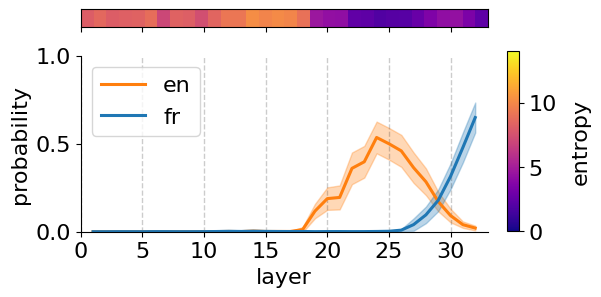

In [19]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

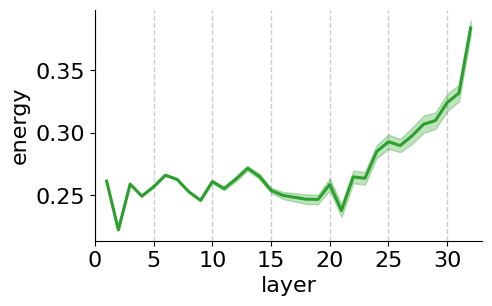

In [20]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')